In [9]:
import seesaw

In [10]:
import os
import importlib
import numpy as np
from tqdm.auto import tqdm

In [11]:
import ray

In [12]:
import seesaw.seesaw_bench
import seesaw.figures

importlib.reload(seesaw.seesaw_bench)
importlib.reload(seesaw.figures)

from seesaw.seesaw_bench import *
from seesaw.figures import *

In [14]:
ray.init('auto', namespace='seesaw')

2022-01-25 12:40:49,587	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.31.130.200:6379


{'node_ip_address': '172.31.130.200',
 'raylet_ip_address': '172.31.130.200',
 'redis_address': '172.31.130.200:6379',
 'object_store_address': '/state/partition1/user/omoll/raytmp/session_2022-01-25_12-37-17_759625_39485/sockets/plasma_store',
 'raylet_socket_name': '/state/partition1/user/omoll/raytmp/session_2022-01-25_12-37-17_759625_39485/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/state/partition1/user/omoll/raytmp/session_2022-01-25_12-37-17_759625_39485',
 'metrics_export_port': 39144,
 'node_id': '12b317727916d143be3aa1e362af19a2623a2ac3039a0bd5a3cc0c7d'}

2022-01-25 12:40:49,830	WARNING worker.py:1219 -- The autoscaler failed with the following error:
Terminated with signal 15
  File "/home/gridsan/omoll/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 543, in <module>
    monitor.run()
  File "/home/gridsan/omoll/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 439, in run
    self._run()
  File "/home/gridsan/omoll/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 346, in _run
    time.sleep(AUTOSCALER_UPDATE_INTERVAL_S)



In [15]:
import importlib

In [16]:
results_path = '/home/gridsan/omoll/bench_results/bench_eQtGlaAAtM/'
stats = get_metrics_table(results_path, at_N=300)

Map Progress: 100%|██████████| 200/200 [00:01<00:00, 169.56it/s]
/home/gridsan/omoll/seesaw/seesaw/figures.py:163: RuntimeWarning: invalid value encountered in floor_divide


In [17]:
stats.to_parquet('/home/gridsan/omoll/bench_results/bench_eQtGlaAAtM/computed_metrics.parquet')

In [18]:
stats = stats.assign(dataset=stats.d_name,
                     index_name=stats.i_name,
                        category=stats.ground_truth_category,
                     variant=stats.name)

In [19]:
stats = stats.assign(variant=stats.variant.map(lambda x : {'baseline':'plain', 'multi':'multiplain'}.get(x,x)))

In [20]:
stats = stats.assign(reciprocal_12=1./stats.nfirst2second_batch)

In [21]:
(stats.nfirst == np.inf).sum()

21

In [22]:
stats.assign(first2sec_NA=stats.nfirst2second_batch.isna()).groupby(['dataset']).first2sec_NA.sum()

dataset
data/bdd/            0
data/coco/           0
data/dota/           0
data/lvis/         207
data/objectnet/      0
Name: first2sec_NA, dtype: int64

In [60]:
# paper: stop at 10 batches of 3
## check NDCG score of that.

### task

by dataset


,multiplain,plain,seesaw,num_queries
dataset,,,,
data/bdd/,0.874548,0.952586,0.896552,29
data/coco/,1.000000,1.000000,1.000000,80
data/dota/,1.000000,0.911111,1.000000,15
data/lvis/,0.885921,0.818793,0.893649,1203
data/objectnet/,0.899807,0.901946,0.902774,313


by query


,better,same,worse,total
dataset,,,,
data/bdd/,1,24,4,29
data/coco/,0,80,0,80
data/dota/,2,13,0,15
data/lvis/,219,850,59,1128
data/objectnet/,21,282,10,313
total,243,1249,73,1565


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset         &         &       &        &        \\
\midrule
data/bdd/       &       1 &    24 &      4 &     29 \\
data/coco/      &       0 &    80 &      0 &     80 \\
data/dota/      &       2 &    13 &      0 &     15 \\
data/lvis/      &     219 &   850 &     59 &   1128 \\
data/objectnet/ &      21 &   282 &     10 &    313 \\
total           &     243 &  1249 &     73 &   1565 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1640.0


part,.1,.3,1.
variant,,,
counts,170,80,1390
baseline,.05,.17,.97
this work,.29,.56,.96
ratio,5.59,3.37,1.00


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &  170 &   80 & 1390 \\
baseline  &  .05 &  .17 &  .97 \\
this work &  .29 &  .56 &  .96 \\
ratio     & 5.59 & 3.37 & 1.00 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.17,NaN,.97,NaN
+ multiscale search,.22,.17,.46,.29,.96,-0.01
+ feedback fusion,.29,.07,.56,.10,.96,.00


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .17 &       NaN & .97 &       NaN \\
+ multiscale search & .22 &       .17 & .46 &       .29 & .96 &     -0.01 \\
+ feedback fusion   & .29 &       .07 & .56 &       .10 & .96 &       .00 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.051932,NaN,0.166017,NaN,0.965933,NaN
+ multiscale search,0.218687,0.166755,0.459714,0.293697,0.960406,-0.005527
+ feedback fusion,0.290310,0.071623,0.559465,0.099751,0.963952,0.003545


/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 75 rows containing missing values.


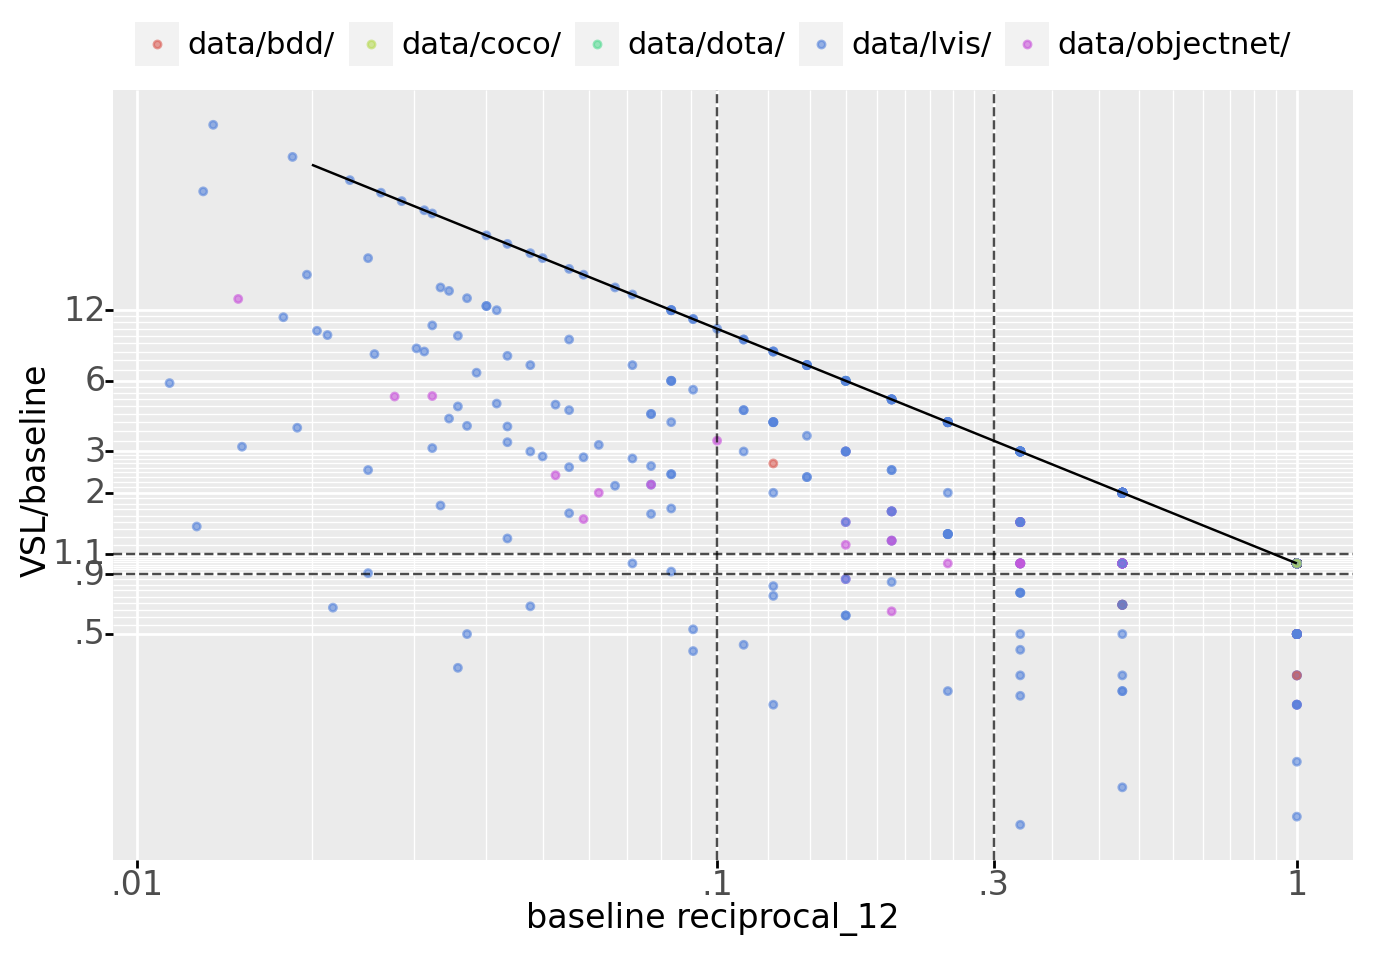

<ggplot: (8789999239677)>

In [24]:
print_tables(stats,variant='seesaw', baseline_variant='plain', metric='reciprocal_12', reltol=1.05)

In [29]:
plotdata = Out[24].data

In [58]:
by_metric = plotdata[plotdata.ratio > 2].sort_values(['ratio'])

In [59]:
by_metric

,dataset,category,variant,ntotal,abundance,reciprocal_12,nfound_x,nfirst_x,base_reciprocal_12,nfound_y,nfirst_y,base,ratio,delta,better,worse,same
1521,data/lvis/,palette,seesaw,27,0.026188,0.142857,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",49.0,0.066667,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",15.0,0.066667,2.142857,0.076190,True,False,False
4351,data/objectnet/,letter opener,seesaw,68,0.001353,0.166667,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,0.076923,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,0.076923,2.166667,0.089744,True,False,False
903,data/lvis/,coil,seesaw,5,0.005903,0.166667,"[1, 2, 3, 4, 5]",183.0,0.076923,"[1, 2, 3, 4, 5]",190.0,0.076923,2.166667,0.089744,True,False,False
2496,data/lvis/,mitten,seesaw,73,0.070736,0.333333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,0.142857,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,0.142857,2.333333,0.190476,True,False,False
4574,data/lvis/,boxing glove,seesaw,8,0.007498,0.333333,"[1, 2, 3, 4, 5, 6, 7, 8]",1.0,0.142857,"[1, 2, 3, 4, 5, 6, 7, 8]",1.0,0.142857,2.333333,0.190476,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,data/lvis/,bubble gum,seesaw,5,0.004941,1.000000,"[1, 2, 3, 4, 5]",1.0,0.026316,"[1, 2, 3, 4, 5]",26.0,0.026316,38.000000,0.973684,True,False,False
1839,data/lvis/,puncher,seesaw,3,0.005566,0.500000,"[1, 2, 3]",3.0,0.012987,"[1, 2, 3]",28.0,0.012987,38.500000,0.487013,True,False,False
3683,data/lvis/,radar,seesaw,5,0.005025,1.000000,"[1, 2, 3, 4, 5]",6.0,0.023256,"[1, 2, 3, 4, 5]",19.0,0.023256,43.000000,0.976744,True,False,False
1047,data/lvis/,drill,seesaw,21,0.020751,1.000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,0.018519,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",25.0,0.018519,54.000000,0.981481,True,False,False


In [41]:
tmp = stats[stats.category == 'goldfish']

In [50]:
metrics = ['nfirst_batch', 'nfirst2second_batch']

In [51]:
order_metric = 'nfirst2second_batch'

In [57]:
tmp[['name', 'category', 'dataset', 'ntotal', 'abundance', 'session_path'] + metrics]

,name,category,dataset,ntotal,abundance,session_path,nfirst_batch,nfirst2second_batch
848,seesaw,goldfish,data/lvis/,3,0.003708,/home/gridsan/omoll/bench_results/bench_eQtGla...,0.0,39.0
2207,baseline,goldfish,data/lvis/,3,0.003708,/home/gridsan/omoll/bench_results/bench_eQtGla...,0.0,3.0
4032,multi,goldfish,data/lvis/,3,0.003708,/home/gridsan/omoll/bench_results/bench_eQtGla...,0.0,89.0


In [47]:
for p in tmp.session_path.values:
    print(p)

/home/gridsan/omoll/bench_results/bench_eQtGlaAAtM/session_20220124-175659_arvakczfvi/
/home/gridsan/omoll/bench_results/bench_eQtGlaAAtM/session_20220124-173608_ovyhbgvkdl/
/home/gridsan/omoll/bench_results/bench_eQtGlaAAtM/session_20220124-174439_ayevgtuxza/


In [ ]:
sbs = side_by_side_comparison(stats, 'plain', metric='ndcg_score')

In [ ]:
sbs2 = sbs[(sbs.variant == variant)][['dataset', 'category', 'ndcg_score', 'base_ndcg_score', 'nfirst_x', 'nfirst_y', 'nfound_x', 'nfound_y']]

In [ ]:
sbs2[(sbs2.ndcg_score > 0) & (sbs2.base_ndcg_score == 0)].shape

In [ ]:
sbs2[(sbs2.ndcg_score == 0) & (sbs2.base_ndcg_score > 0)]

In [ ]:
variant='multiplain_warm_vec_only'
print_tables(stats,variant=variant)

In [ ]:
stats100_objnet_lrsmall,_ = process_tups(results_on1, at_N=100)

In [ ]:
print_tables(stats100_objnet_lrsmall, variant='multiplain_warm_vec_fast')

In [ ]:
stats100_feedback10,_ = process_tups(new_results, at_N=100)

In [ ]:
print_tables(stats100_feedback10, variant='multiplain_warm_vec_fast')

In [ ]:
#stats100_feedback10

In [ ]:
print_tables(stats30, variant='multiplain_warm_vec_fast')

In [ ]:
print_tables(stats, variant='multiplain_warm_vec_fast')

In [ ]:
print_tables(stats, variant='multiplain_warm_vec_fast')

In [ ]:
print_tables(evs2, variant='multiplain_warm_vec_fast_new', resultlist=results, at_N=100)

In [ ]:
Out[101]

In [ ]:
print_tables(evs2, variant='multiplain_warm_vec_fast', resultlist=results, at_N=100)

In [ ]:
print_tables(evs2, variant='multiplain_warm_vec_fast', resultlist=results, at_N=30)

In [ ]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

In [ ]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

In [ ]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

In [ ]:
bsw_table(stats, reltol=1.1)

In [ ]:
bsw_table(stats, reltol=1.1)

In [ ]:
bsw_table(stats, reltol=1.1)

In [ ]:
bsw = bsw_table(stats)

In [ ]:
from seesaw 

In [ ]:
sbs = better_same_worse(stats, variant='multiplain_warm_vec_only', summary=False)

In [ ]:
tot_res = summary_breakdown(sbs)
#.groupby(['dataset', 'variant']).category.apply(lambda x : x.unique().shape[0]).unstack(level=-1)

In [ ]:
comparison_table(tot_res)

In [ ]:
ablation_table(tot_res)

In [ ]:
ablation_table(tot_res)

In [ ]:
plotdata = sbs[sbs.variant == 'multiplain_warm_vec_only']

In [ ]:
make_labeler.__module__

In [ ]:
ablation_table(tot_res)

x = np.geomspace(.02, 1, num=5)
y = 1/x
diag_df = pd.DataFrame({'x':x, 'y':y})

scatterplot = (ggplot(plotdata)
    + geom_point(aes(x='base', y='ratio', fill='dataset', color='dataset'), alpha=.6, size=1.) 
#                 shape=plotdata.dataset.map(lambda x : '.' if x in ['lvis','objectnet'] else 'o'), 
#                 size=plotdata.dataset.map(lambda x : 1. if x in ['lvis','objectnet'] else 2.))
#  + geom_text(aes(x='base', y='delta', label='category', color='dataset'), va='bottom', 
#              data=plotdata1[plotdata1.ratio < .6], 
#              position=position_jitter(.05, .05), show_legend=False)
    + geom_line(aes(x='x', y='y'), data=diag_df)
 + ylab('VSL/baseline')
#               + geom_area(aes(y2=1.1, y=.9), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=1.1), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=.9), linetype='dashed', alpha=.7)


                + geom_vline(aes(xintercept=.1,), linetype='dashed', alpha=.7)
                + geom_vline(aes(xintercept=.3,), linetype='dashed', alpha=.7)
#+ geom_abline()
#    + geom_point(aes(x='recall', y='precision', color='variant'), size=1.)
#     + facet_wrap(facets=['cat'], ncol=6, scales='free_x')
 + xlab('baseline NDCG')
# +scale_color_discrete()
    + theme(figure_size=(8,5), legend_position='top',
           subplots_adjust={'hspace': 0.5}, legend_title=element_blank(),
            legend_box_margin=-1, legend_margin=0.,
            axis_text=element_text(size=12, margin={'t':.2, 'l':-.3}),
            legend_text=element_text(size=11),
            axis_title=element_text(size=12, margin={'r':-.2, 'b':0., 'l':0, 't':0.}),
           )
    + scale_x_log10(labels=make_labeler(brief_format), breaks=[.01, .1, .3, 1.])
    + scale_y_log10(labels=make_labeler(brief_format), breaks=[.5, 0.9, 1.1, 2., 3.,6, 12])
)

scatterplot

In [ ]:
scatterplot.save('/home/gridsan/omoll/seesaw.scatterfull.png')

In [ ]:
x = np.geomspace(.02, 1, num=5)
y = 1/x
diag_df = pd.DataFrame({'x':x, 'y':y})

scatterplot = (ggplot(plotdata)
    + geom_point(aes(x='base', y='ratio', fill='dataset', color='dataset'), alpha=.6, size=1.) 
#                 shape=plotdata.dataset.map(lambda x : '.' if x in ['lvis','objectnet'] else 'o'), 
#                 size=plotdata.dataset.map(lambda x : 1. if x in ['lvis','objectnet'] else 2.))
#  + geom_text(aes(x='base', y='delta', label='category', color='dataset'), va='bottom', 
#              data=plotdata1[plotdata1.ratio < .6], 
#              position=position_jitter(.05, .05), show_legend=False)
    + geom_line(aes(x='x', y='y'), data=diag_df)
 + ylab('VSL/baseline')
#               + geom_area(aes(y2=1.1, y=.9), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=1.1), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=.9), linetype='dashed', alpha=.7)


                + geom_vline(aes(xintercept=.1,), linetype='dashed', alpha=.7)
                + geom_vline(aes(xintercept=.3,), linetype='dashed', alpha=.7)
#+ geom_abline()
#    + geom_point(aes(x='recall', y='precision', color='variant'), size=1.)
#     + facet_wrap(facets=['cat'], ncol=6, scales='free_x')
 + xlab('baseline NDCG')
# +scale_color_discrete()
    + theme(figure_size=(8,5), legend_position='top',
           subplots_adjust={'hspace': 0.5}, legend_title=element_blank(),
            legend_box_margin=-1, legend_margin=0.,
            axis_text=element_text(size=12, margin={'t':.2, 'l':-.3}),
            legend_text=element_text(size=11),
            axis_title=element_text(size=12, margin={'r':-.2, 'b':0., 'l':0, 't':0.}),
           )
    + scale_x_log10(labels=make_labeler(brief_format), breaks=[.01, .1, .3, 1.])
    + scale_y_log10(labels=make_labeler(brief_format), breaks=[.5, 0.9, 1.1, 2., 3.,6, 12])
)

scatterplot

In [ ]:
cats = plotdata[plotdata.dataset == 'lvis'].sort_values('nfirst_y', ascending=False)[['category', 'nfirst_x', 'nfirst_y']].reset_index(drop=True)

In [ ]:
cats.to_parquet('./data/cats_lvis_ordered.parquet')

In [ ]:
sbs[(sbs.nfirst_x <= 5) & (sbs.nfirst_y > 20) & (sbs.variant == 'multiplain_warm_vec_only')]

In [ ]:
# hot air balloon